In [1]:
# %% import labraries
import pickle
from gurobipy import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pickle
with open('B.pickle', 'rb') as handle:
    B_pickle = pickle.load(handle)


In [3]:
with open('R.pickle', 'rb') as handle:
    R_pickle = pickle.load(handle)


Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-14
Set parameter MIPGap to value 0
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 690 rows, 196 columns and 3078 nonzeros
Model fingerprint: 0x48f1622c
Variable types: 0 continuous, 196 integer (184 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 468 rows and 90 columns
Presolve time: 0.00s
Presolved: 222 rows, 106 columns, 948 nonzeros
Variable types: 0 continuous, 106 integer (94 binary)
Found heuristic solution: objective 340.0000000
Found heuristic solution: objective 200.0000000

Root relaxation: objective 1.400000e+02, 14 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective

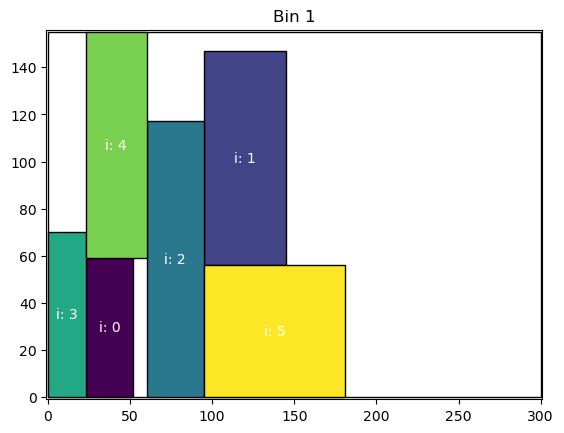

0 0 0.0 0.0 0.0
0 1 0.0 0.0 0.0
0 2 0.0 0.0 0.0
0 3 0.0 0.0 0.0
0 4 0.0 0.0 1.0
0 5 0.0 0.0 1.0


In [4]:
# %% Set model name
model = Model('2D Bin Packing Optimization')

# %% ---- Sets ----
#I = list(range(len(R_pickle)))
I = list(range(6))
B = list(range(len(B_pickle)))


# %% ---- Parameters ----
item_length = [value[0] for key, value in R_pickle.items()]
item_height = [value[1] for key, value in R_pickle.items()]
rotatable = [value[2] for key, value in R_pickle.items()]
fragile = [value[3] for key, value in R_pickle.items()]
perishable = [value[4] for key, value in R_pickle.items()] 
radioactive = [value[5] for key, value in R_pickle.items()]

bin_type = [value[0] for key, value in B_pickle.items()]
bin_length = [value[1][0] for key, value in B_pickle.items()]
bin_height = [value[1][1] for key, value in B_pickle.items()]
bin_available = [value[1][2] for key, value in B_pickle.items()]
bin_cost = [value[1][3] for key, value in B_pickle.items()]
bin_slope = [value[1][4] for key, value in B_pickle.items()]
bin_intercept = [value[1][5] for key, value in B_pickle.items()]


# big M
M = 100000

# %% ---- Variables ----
# p_{ib} variable, 1 if box i is in container b, 0 otherwise
p = {}
for i in I:
     for b in B:
          p[i,b] = model.addVar (vtype = GRB.BINARY, name = 'p[' + str(i) + ',' + str(b) + ']' )

# z_{b} variable, 1 if container b is used, 0 otherwise
z = {}
for b in B:
     z[b] = model.addVar(vtype = GRB.BINARY, name = 'z[' + str(b) + ']' )

# l_{ij} variable, 1 if item i is to the left of item j, 0 otherwise
l = {}
for i in I:
     for j in I:
          l[i,j] = model.addVar(vtype = GRB.BINARY, name = 'l[' + str(i) + ',' + str(j) + ']' )

# u_{ij} variable, 1 if item i is under item j, 0 otherwise
u = {}
for i in I:
     for j in I:
          u[i,j] = model.addVar(vtype = GRB.BINARY, name = 'u[' + str(i) + ',' + str(j) + ']' )

# r_{i, L^, L} variable, 1 if the original item i is aligned with the length side of the bin
r = {}
for i in I:
     r[i] = model.addVar(vtype = GRB.BINARY, name = 'r[' + str(i) + ']' )

# x_{i} variable, x coordiante of lower_left corner of item i, with respect to origin of bin b
x = {}
for i in I:
     x[i] = model.addVar(vtype = GRB.INTEGER, name = 'x[' + str(i) + ']' )

# y_{i} variable, y coordiante of lower_left corner of item i, with respect to origin of bin b
y = {}
for i in I:
     y[i] = model.addVar(vtype = GRB.INTEGER, name = 'y[' + str(i) + ']'  )

# g_{i} variable, 1 if item i lies on the ground of the bin it is assigned to
g = {}
for i in I:
     g[i] = model.addVar(vtype = GRB.BINARY, name = 'g[' + str(i) + ']')

# b^{1}_{i,j} variable, 1 if vertex 1 of item i is supported by item j
b1 = {}
for i in I:
     for j in I:
          b1[i,j] = model.addVar(vtype = GRB.BINARY, name = 'b1[' + str(i) + ',' + str(j) + ']' ) 

# b^{2}_{i,j} variable, 1 if vertex 1 of item i is supported by item j
b2 = {}
for i in I:
     for j in I:
          b2[i,j] = model.addVar(vtype = GRB.BINARY, name = 'b2[' + str(i) + ',' + str(j) + ']' ) 


# %% ---- Integrate new variables ----
model.update()

# %% ---- Objective Function ----
model.setObjective (quicksum(bin_cost[b] * z[b] for b in B))
model.modelSense = GRB.MINIMIZE
model.update ()

# Constraint 2: Ensures that there is a value for the l and u constraints if two items are in the same box 
con2 = {}
for i in I:
     for j in I:
          for b in B:
               if i != j:
                    con2[i,j,b] = model.addConstr(l[i,j] + l[j,i] + u[i,j] + u[j,i] >= (p[i,b] + p[j,b] -1), 'con2[' + str(i) + ', ' + str(j) + ', ' + str(b) + ']-')     

# Constraint 3: Mutual positioning along the x axis 1
con3 = {}
for i in I:
     for j in I:
          for b in B:
               if i != j:
                    con3[i,j,b] = model.addConstr(x[j] >= x[i] + item_length[i] * r[i] + item_height[i] * (1- r[i]) - M * (1- l[i,j]), 'con3[' + str(i) + ', ' + str(j) + ', ' + str(b) + ']-')   

# Constraint 4: Mutual positioning along the x axis 2
con4 = {}
for i in I:
     for j in I:
          for b in B:
               if i != j:
                    con4[i,j,b] = model.addConstr(x[j] <= x[i] + item_length[i] * r[i] + item_height[i] * (1- r[i]) + M * l[i,j], 'con4[' + str(i) + ', ' + str(j) + ', ' + str(b) + ']-')   

                   
# Constraint 5: Mutual positioning along the y axis 1
con5 = {}
for i in I:
     for j in I:
          for b in B:
               if i != j:
                    con5[i,j,b] = model.addConstr(y[j] >= y[i] + item_length[i] * (1- r[i]) + item_height[i] * r[i] - M * (1- u[i,j]), 'con5[' + str(i) + ', ' + str(j) + ', ' + str(b) + ']-')   

# Constraint 6: Mutual positioning along the y axis 2
con6 = {}
for i in I:
     for j in I:
          for b in B:
               if i != j:
                    con6[i,j,b] = model.addConstr(y[j] <= y[i] + item_length[i] * (1- r[i]) + item_height[i] * r[i] + M * u[i,j], 'con6[' + str(i) + ', ' + str(j) + ', ' + str(b) + ']-')   

# Constraint 7: Ensure that the lower-right vertex of item i is contained within bin b.
con7 = {}
for i in I:
     for b in B:
          con7[i,b] = model.addConstr(x[i] + item_length[i] * r[i] + item_height[i] * (1- r[i]) <= quicksum(bin_length[b] * p[i,b] for b in B), 'con7[' + str(i) + ', ' + str(b) + ']-')  

# Constraint 8: Ensure that the upper-right vertex of item i is contained within bin b.
con8 = {}
for i in I:
     for b in B:
          con8[i,b] = model.addConstr(y[i] + item_length[i] * (1- r[i]) + item_height[i] * r[i] <= quicksum(bin_height[b] * p[i,b] for b in B), 'con8[' + str(i) + ', ' + str(b) + ']-')  

# Constraint 11: item assignment to bin
con11 = {}
for i in I:
    con11[i] = model.addConstr(quicksum(p[i,b] for b in B )  == 1, 'con11[' + str(i) + ']-'    )

# Constraint 12: bin flagged as used
con12 = {}
for i in I:
     for b in B:
         con12[i,b] = model.addConstr(z[b] >= p[i,b], 'con12[' + str(i) + ', ' + str(b) + ']-'    )     


# Constraint 13: Incompatible combination constraint


# Constraint 14: Support constraint
con14 = {}
for i in I:
     con14[i] = model.addConstr(quicksum(b1[i,j] + b2[i,j] + 2*g[i] for j in I if i != j )== 2, 'con14[' + str(i) + ']-'    )

# Constraint 15: Gravity constraint
con15 = {}
for i in I:
     con15[i] = model.addConstr(y[i] <= M * (1- g[i]),  'con15[' + str(i) + ']-'     )


'''
# Constraint 16
con16 = {}
for i in I:
     for j in I:
          if i != j:
               con16[i,j] = model.addConstr(y[i] <= y[j] + item_height[j] * r[j] + item_length[j] * (1- r[j]) + M * (1-b1[i,j]), 'con16[' + str(i) + ', ' + str(j) + ']-'    )     

# Constraint 17: Vertex one supported by box below
con17 = {}
for i in I:
     for j in I:
          if i != j:
               con17[i,j] = model.addConstr(x[i] >= x[j] * b1[i,j], 'con17[' + str(i) + ', ' + str(j) + ']-')   

# Constraint 18: Vertex two supported by box below
con18 = {}
for i in I:
     for j in I:
          if i != j:
               con18[i,j] = model.addConstr(x[i] + item_length[i] * r[i] + item_height[i] * (1- r[i]) <= x[j] + item_length[j] * r[j] + item_height[j] * (1- r[j]) + M * (1- b2[i,j]), 'con18[' + str(i) + ', ' + str(j) + ']-')   


# Constraint 19
con19 = {}
for i in I:
     con19[i] = model.addConstr(quicksum(b1[i,j] for j in I if i != j) == quicksum(b2[i,j] for j in I if i != j),'con19[' + str(i) + ']-'  )

# Constraint 20
con20 = {}
for i in I:
     con20[i] = model.addConstr(quicksum(b1[i,j] * x[j] for j in I) <= quicksum(b2[i,j] * x[j] for j in I),'con20[' + str(i) + ']-'  )
'''



# %%  ---- Solve ----
model.setParam( 'OutputFlag', True) # silencing gurobi output or not
model.setParam ('MIPGap', 0);       # find the optimal solution
model.setParam('TimeLimit', 300)  # TimeLimit of five minutes
model.write("output.lp")            # print the model in .lp format file
model.optimize ()

if model.status == GRB.Status.OPTIMAL: # If optimal solution is found
    print ('Optimal olution found, minimal costs: ' + '%10.3f' % model.objVal + ' euros'  )  
    print ('')
elif model.status == GRB.TIME_LIMIT:
    print ('Time Limit solution found, minimal costs: ' + '%10.3f' % model.objVal + ' euros'  )  
    print ('')
else:
    print ('\nNo feasible solution found')


# %%

if model.status == GRB.Status.OPTIMAL or model.status == GRB.Status.TIME_LIMIT: # If solution is found
    # Define a list of colors for the small rectangles
    colors = plt.cm.viridis(np.linspace(0, 1, len(I)))
    for b in B:
        if z[b].x == 1.0:
            # Set the width and height of the bin
            b_length = bin_length[b]
            b_height = bin_height[b]

            # Create a figure and axis object
            fig, ax = plt.subplots()

            # Add a rectangle to the axis
            rect_bin = plt.Rectangle((0, 0), b_length, b_height, linewidth=1, edgecolor='black', facecolor='none')
            ax.add_patch(rect_bin)

            for i in I:
                if p[i,b].x == 1.0:
                    # Set the width and height of the item
                    i_length = item_length[i] * r[i].x + item_height[i] * (1- r[i].x)  
                    i_height = item_height[i] * r[i].x + item_length[i] * (1- r[i].x)  

                    # Set x and y coordinates of bottom left corner
                    x_pos = x[i].x
                    y_pos = y[i].x

                    # Add a rectangle to the axis
                    rect_item = plt.Rectangle((x_pos, y_pos), i_length, i_height, linewidth=1, edgecolor='black', facecolor=colors[i])
                    ax.add_patch(rect_item)
                    ax.text(x_pos + i_length/2, y_pos + i_height/2, 'i: ' + str(i), ha='center', va='center', color='white')
                  
            # Set the limits of the plot
            ax.set_xlim([-1, b_length + 1])
            ax.set_ylim([-1, b_height + 1])

            # Add a title to the plot
            ax.set_title('Bin ' + str(b))

            # Show the plot
            plt.show()               
                        

# %%
if False:
     for b in B:
          for i in I:
               for j in I:       
                    if i != j:
                         print(b, i, j)
                         print(l[i,j].x, l[i,j].x)
                         print(u[i,j].x, u[j,i].x)
                         print(p[i,b].x, p[j,b].x)
                         print()

for i in [0]:
     for j in I:
          print(i, j, g[i].x,b1[i,j].x, b2[i,j].x)

# %%
